In [13]:
import numpy as np
import custom_hd159062_lnlike as custom_lnlike
from orbitize import sampler,driver,kepler,system,results,lnlike
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from astropy.time import Time
from datetime import datetime
import os

In [51]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)
plt.rc('axes', linewidth=3)

In [3]:
def M2tperi(M,P,tref):
    Tp = tref - M*P/(2*np.pi)
    return Tp #time of periastron from mean anomaly

def M2tau0(M,P,tref):
    Tp = M2tperi(M,P,tref)
    tau = Tp/P % 1
    return tau #tau from mean anomaly

def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P #fraction of orbit after tperi

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3) #sma in AU

def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

In [4]:
path = '../tests/'
data = pd.read_csv(path+'testdata0.csv')
parameters = pd.read_csv(path+'test_params.csv',
                        header=None,names=['m0','m1','P','ecc','argp','lan','inc','tperi','plx','gamma','sigma'])
parameters

m0        m1            P       ecc      argp       lan       inc  \
0  1.564479  0.085178  1945.688713  0.122813  2.500799  6.131192  1.073319   
1  1.467623  0.281448  7680.352384  0.541629  3.365739  0.189799  0.766443   
2  1.706174  0.005215  3247.453347  0.440817  5.803546  3.831127  0.651111   
3  1.390054  0.010942  1414.304376  0.219417  3.466953  0.259704  0.889410   
4  2.971407  0.018634  4307.746537  0.418262  2.772717  5.184585  1.509494   

   tperi        plx      gamma      sigma  
0  500.0  67.913080  91.184153   3.286882  
1  500.0  70.358874  43.117884  13.313936  
2  500.0  99.960529  26.053640   7.382694  
3  500.0  95.129581  92.618208   9.715780  
4  500.0  50.011293  37.061491  17.599855

In [5]:
#from period to semi-major axis:
def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0 + m1))**(1/3)
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days
    
#converting from time of periastron (Tp) to epoch of periastron in P praction (tau) for orbitize parameter
def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P
#converting from practional time of periastron (tau) to time of periastron (Tp) for toy parameter
def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P
    
#from our parameter order to orbitize parameter order:
def toy2orb(toy_params):
    orb_order = [2,3,6,4,5,7,8,9,10,1,0]
    orb_realparams = [toy_params[i] for i in orb_order]
    tau = tau0(orb_realparams[5],0.0,orb_realparams[0])
    sma = p2sma(orb_realparams[0],orb_realparams[-1], orb_realparams[-2])
    #mtot = orb_realparams[-1]+orb_realparams[-2]
    orb_realparams[0] = sma
    orb_realparams[5] = tau
    #orb_realparams.append(mtot)
    return orb_realparams #returns real parameters ordered to fit orbitize kepler solver

In [6]:
test_params = toy2orb(parameters.loc[0])
test_params

[3.604014866440558,
 0.12281347690244583,
 1.073318886156944,
 2.5007988258535163,
 6.131192394030213,
 0.25697841420654816,
 67.91307974881711,
 91.1841528143556,
 3.2868818363971983,
 0.08517757310135393,
 1.5644786565229944]

In [7]:
def calc_orbit(theta,time):
    #theta are the parameters (array or list form), and time are the observation epochs (also a list or an array)
    """Arguments (theta):
        [0]: m1 (mass of the star)
        [1]: m2 (mass of orbiting body)
        [2]: P (period in days)
        [3]: ecc (eccentricity between 0.0 and 1.0)
        [4]: argp (argument of periastron)
        [5]: lan (longitude of the ascending node)
        [6]: inc (inclination in radians between 0 and 2pi)
        [7]: tperi (time of periastron in days)
        [8]: plx (parallax in mas)
        [9]: gamma (rv zero-point offset in m/s)
        [10] sigma (jitter in m/s)
        
        time has shape len(N_obs)"""
    #first thing we have to do is figure out the average angular velocity in rad/day:
    n = 2*np.pi/theta[2]
    M = n*(time - theta[7]) #Mean anomaly as a function of time in radians
    M = np.mod(M,2*np.pi)
    
    ecc_arr = np.ones(len(M))*theta[3]
    
    E = kepler._calc_ecc_anom(M,ecc_arr) #eccentric anomaly
    
    nu = 2*np.arctan(np.sqrt((1 + theta[3])/(1 - theta[3]))*np.tan(E/2))
    #print(nu)
    #needed for astrometry data:
    sma = ((theta[2]/365.25)**2*(theta[0] + theta[1]))**(1/3) #calculating the semi-major axis in AU
    
    radius = sma*(1.0 - theta[3]*np.cos(E)) #calculating the radius as a function of E
    
    #X,Y are arrays of length time
    Y = radius*(np.cos(theta[5])*np.cos(theta[4] + nu) - np.sin(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #DEC
    X = radius*(np.sin(theta[5])*np.cos(theta[4] + nu) + np.cos(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #RA
    
    dra = X*theta[8]
    ddec = Y*theta[8]
    
    #needed for radial velocity data:
    #Jupiter in solar masses: 0.0009543:
    m_jup = 0.0009543
    
    #radial velocity amplitude in m/s:
    K0 = (28.4329/np.sqrt(1-theta[3]**2))*\
    (theta[1]*np.sin(theta[6])/m_jup)*((theta[0] + theta[1])**(-2/3))*\
    (theta[2]/365.25)**(-1/3)
    #print(K0)
    
    #Radial velocity in m/s:
    argp_star = theta[4] + np.pi
    rv0 = K0*(np.cos(argp_star + nu) + theta[3]*np.cos(argp_star)) + theta[9] #same shape as nu (same shape as time)
    return dra,ddec,rv0

In [8]:
raoff,decoff,rv = calc_orbit(parameters.loc[0],np.arange(0,parameters.loc[0][2]))

In [23]:
# system parameters
num_secondary_bodies = 1
system_mass = test_params[-1] # [Msol]
plx = test_params[6] # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.05 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 100
num_threads = mp.cpu_count() # or a different number if you prefer


my_driver = driver.Driver(
    '../tests/testdata0.csv', 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-5000, 5000), 'jitter_bounds':(1e-3, 50)},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

In [24]:
total_orbits = 500000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 100 # steps to burn in per walker
thin = 50# only save every 10th step

In [25]:
s = my_driver.sampler

Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

5000/5000 steps completed
Run complete
The chain shape is: (20, 100, 100, 11)


Finished with 0 iterations!
Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

5000/5000 steps completed
Run complete
The chain shape is: (20, 100, 100, 11)


Finished with 1 iterations!
Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

5000/5000 steps completed
Run complete
The chain shape is: (20, 100, 100, 11)


Finished with 2 iterations!
Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

5000/5000 steps completed
Run complete
The chain shape is: (20, 100, 100, 11)


Finished with 3 iterations!
Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

5000/5000 steps completed
Run complete
The chain shape is: (20, 100, 100, 11)


Finished with 4 iterations!


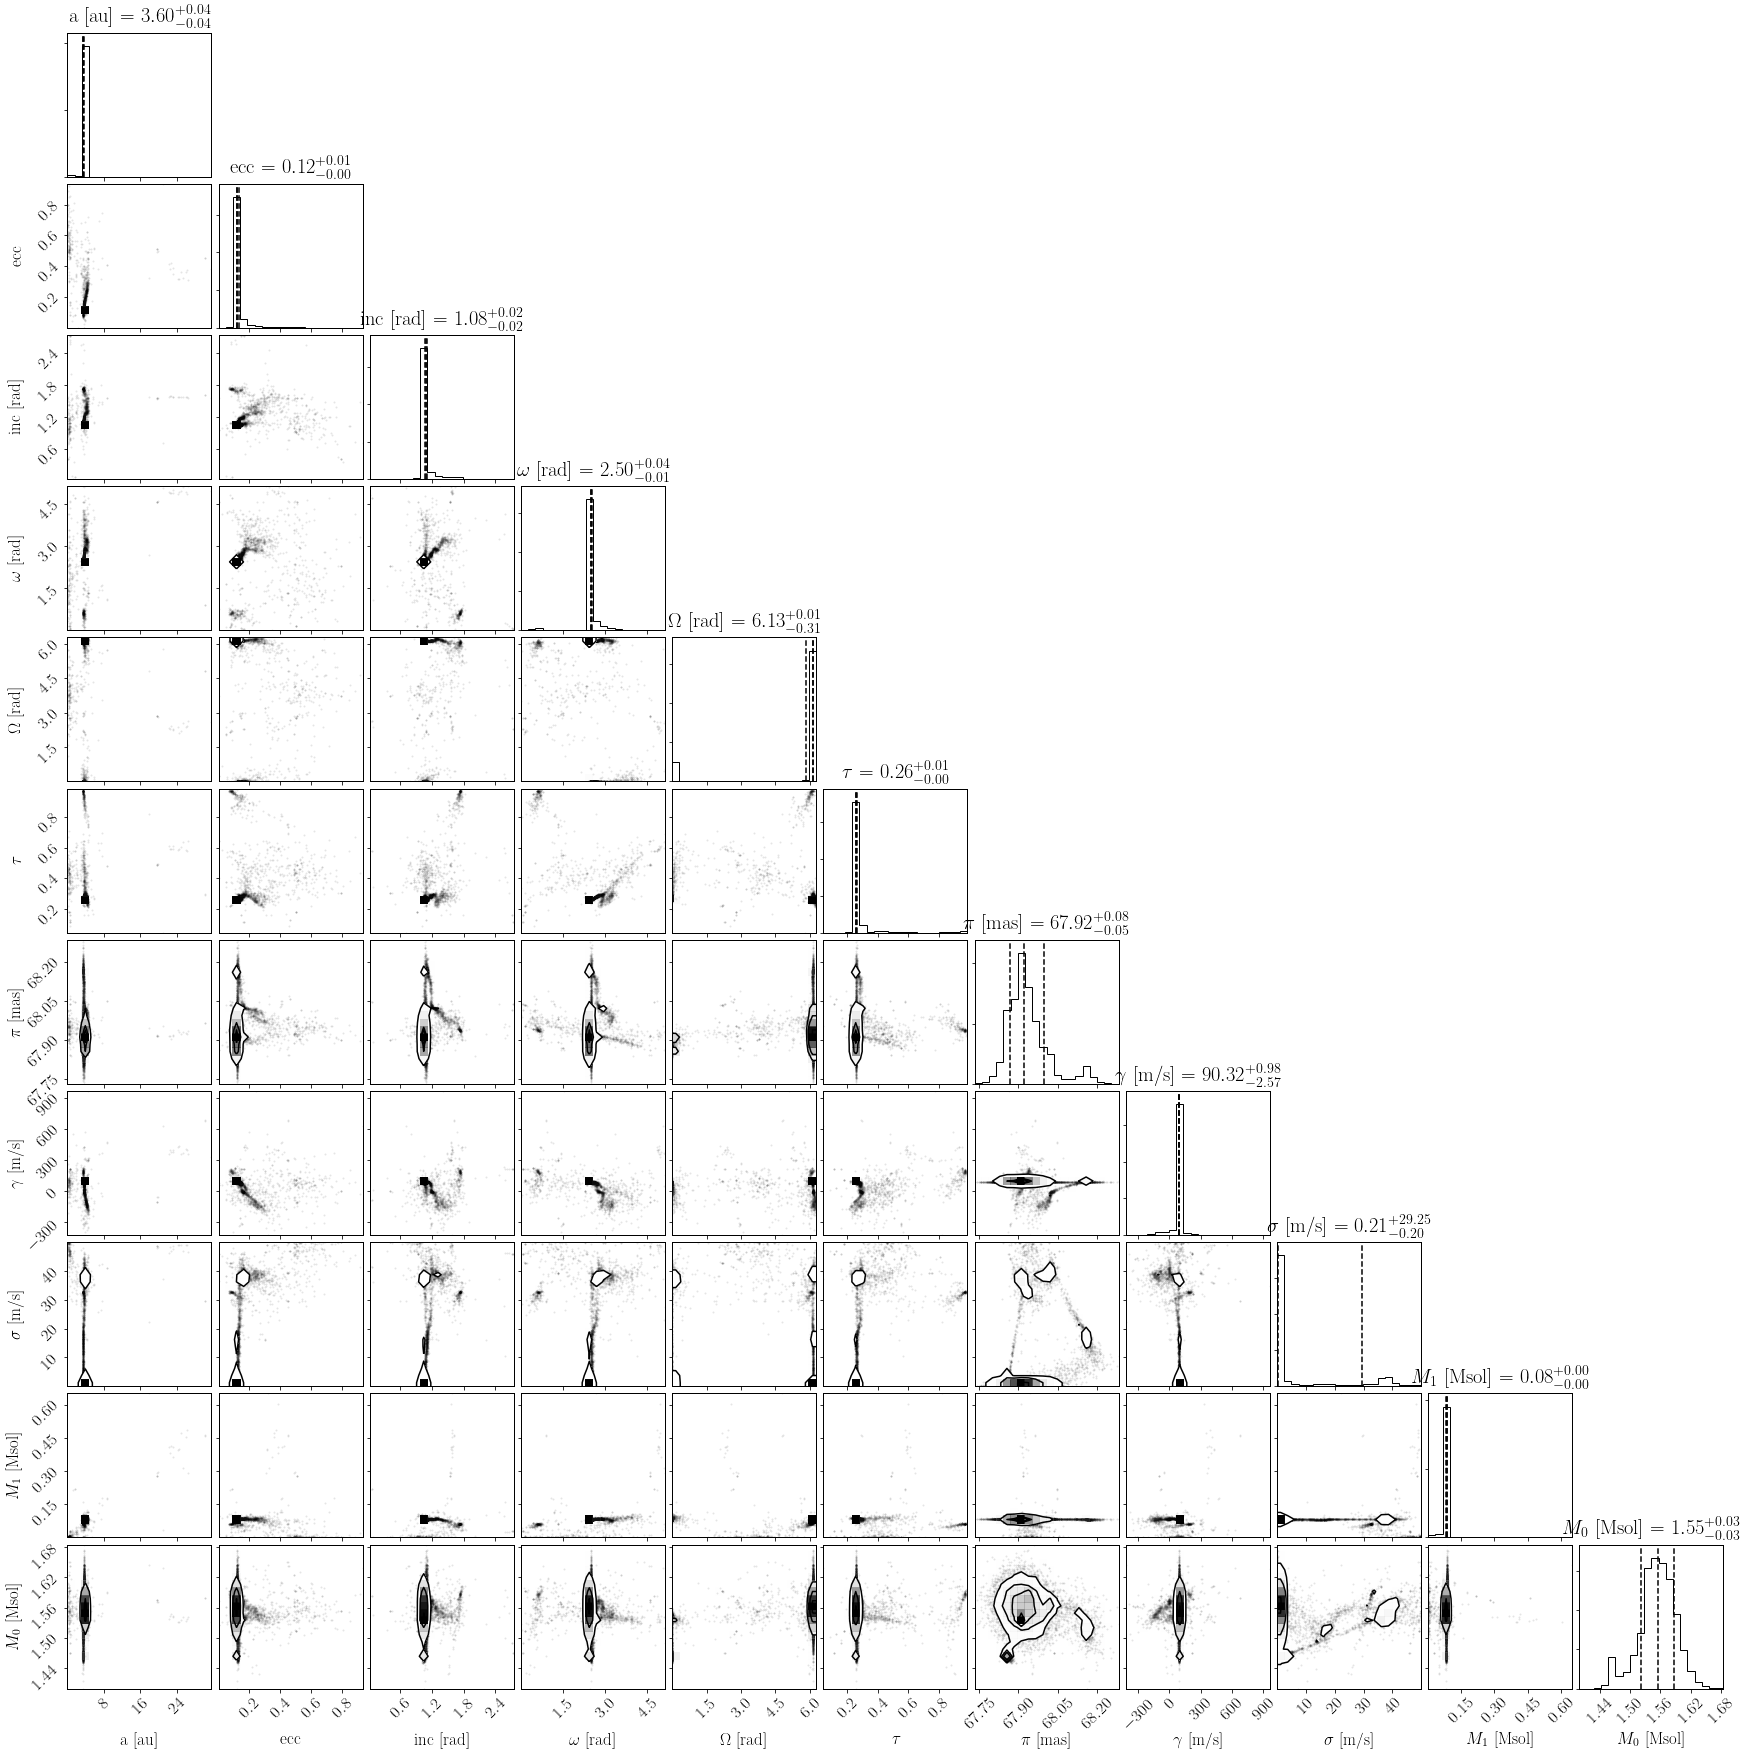

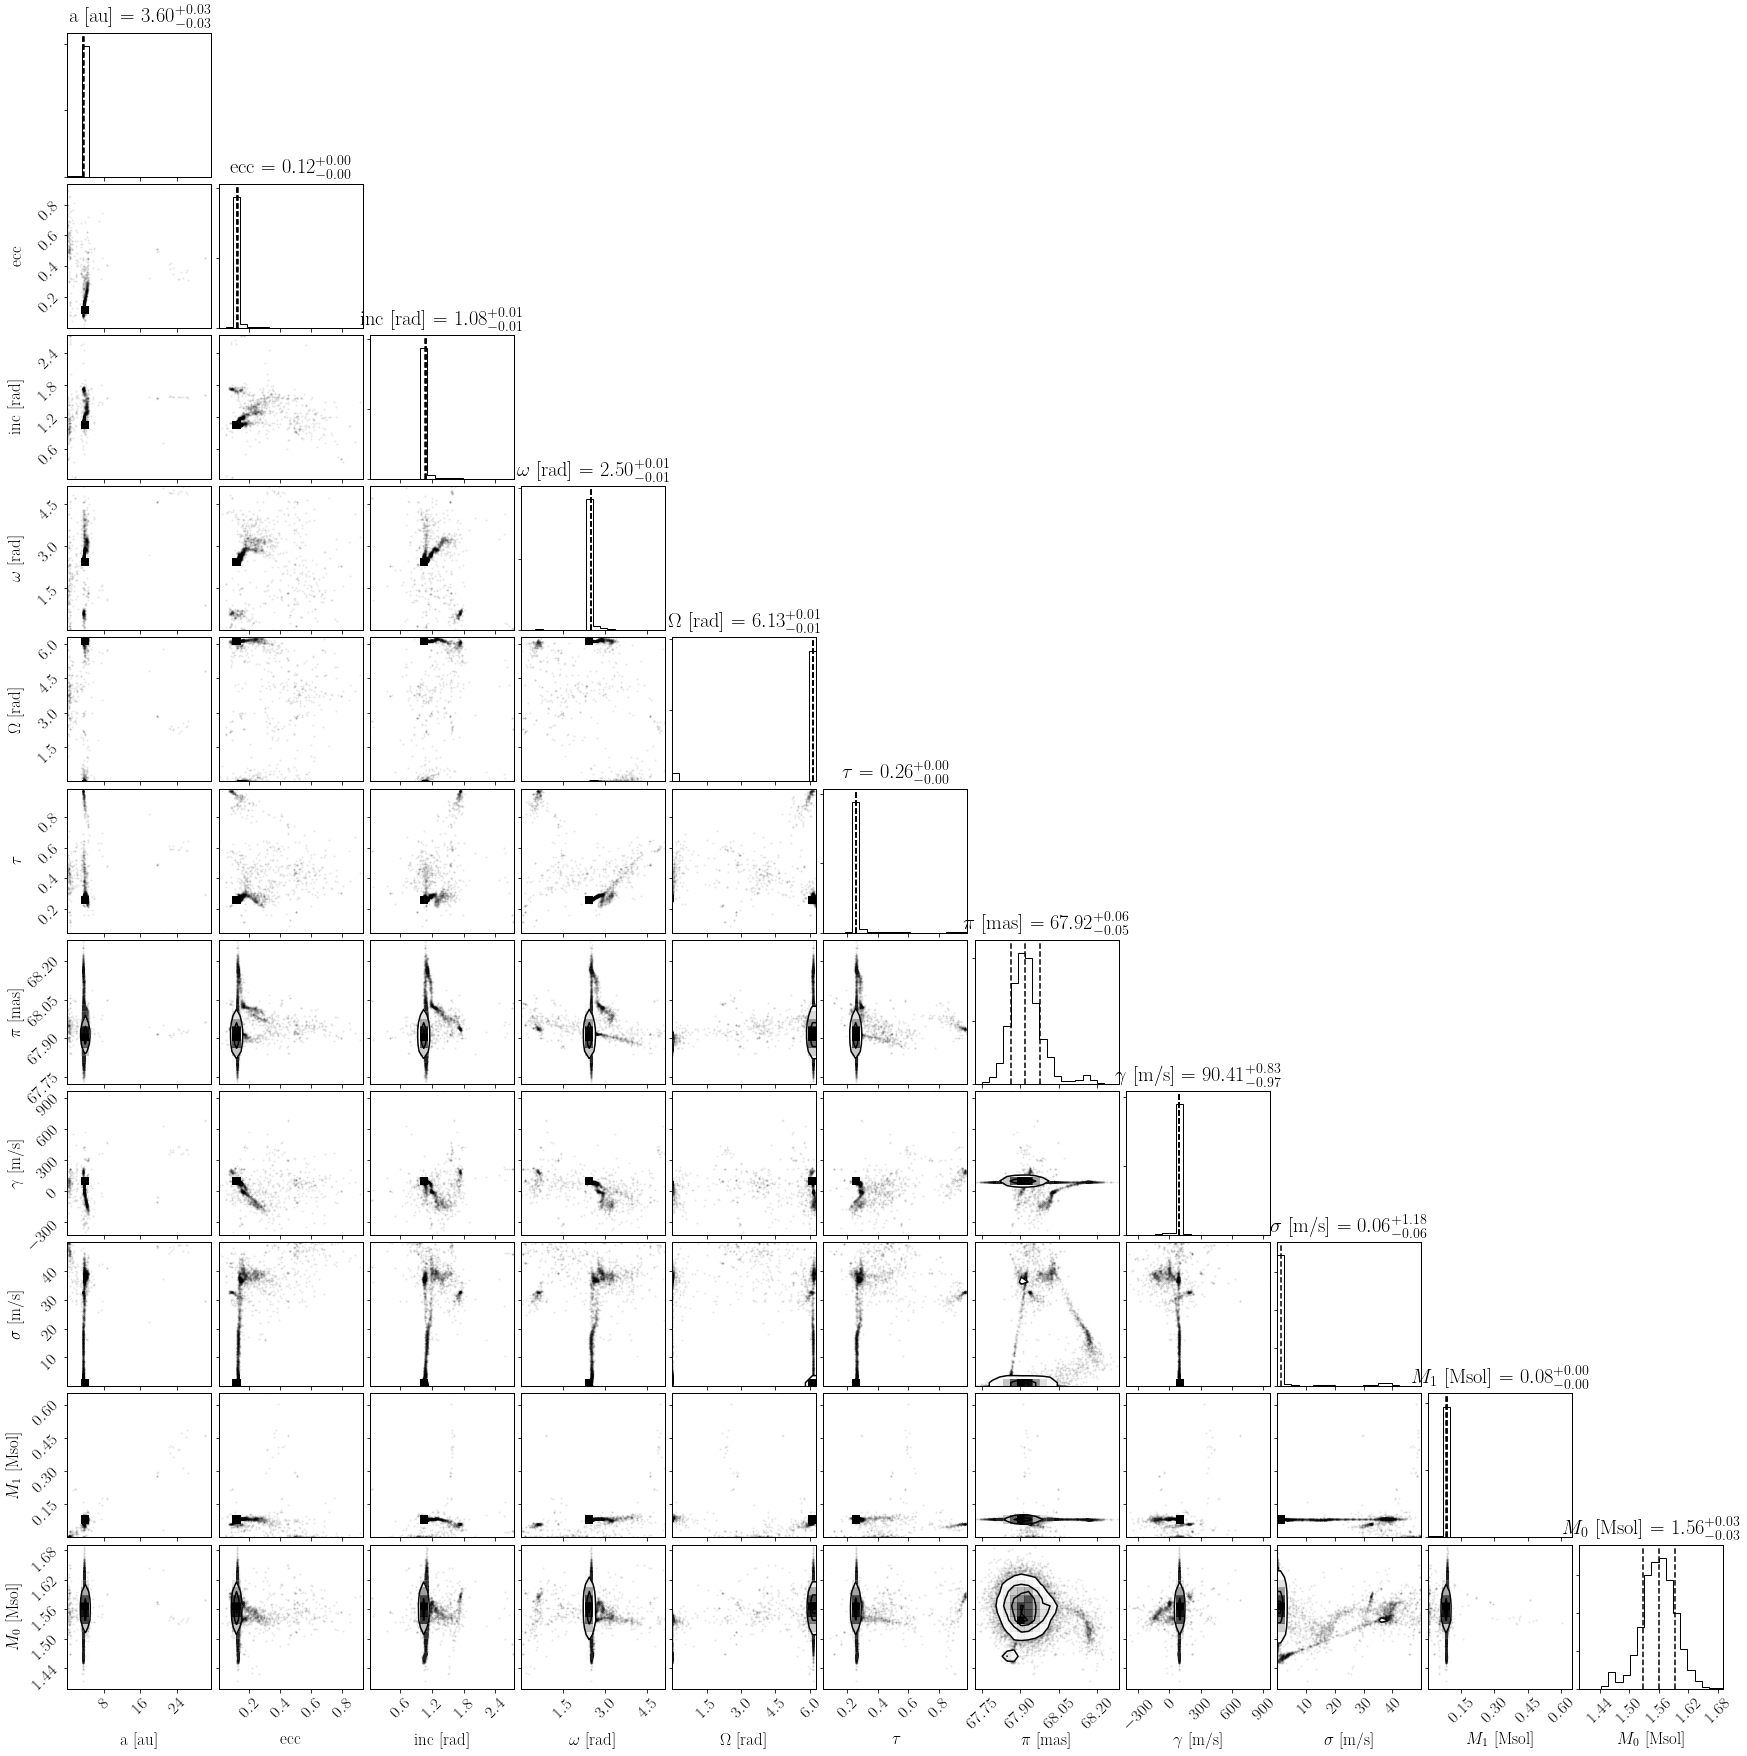

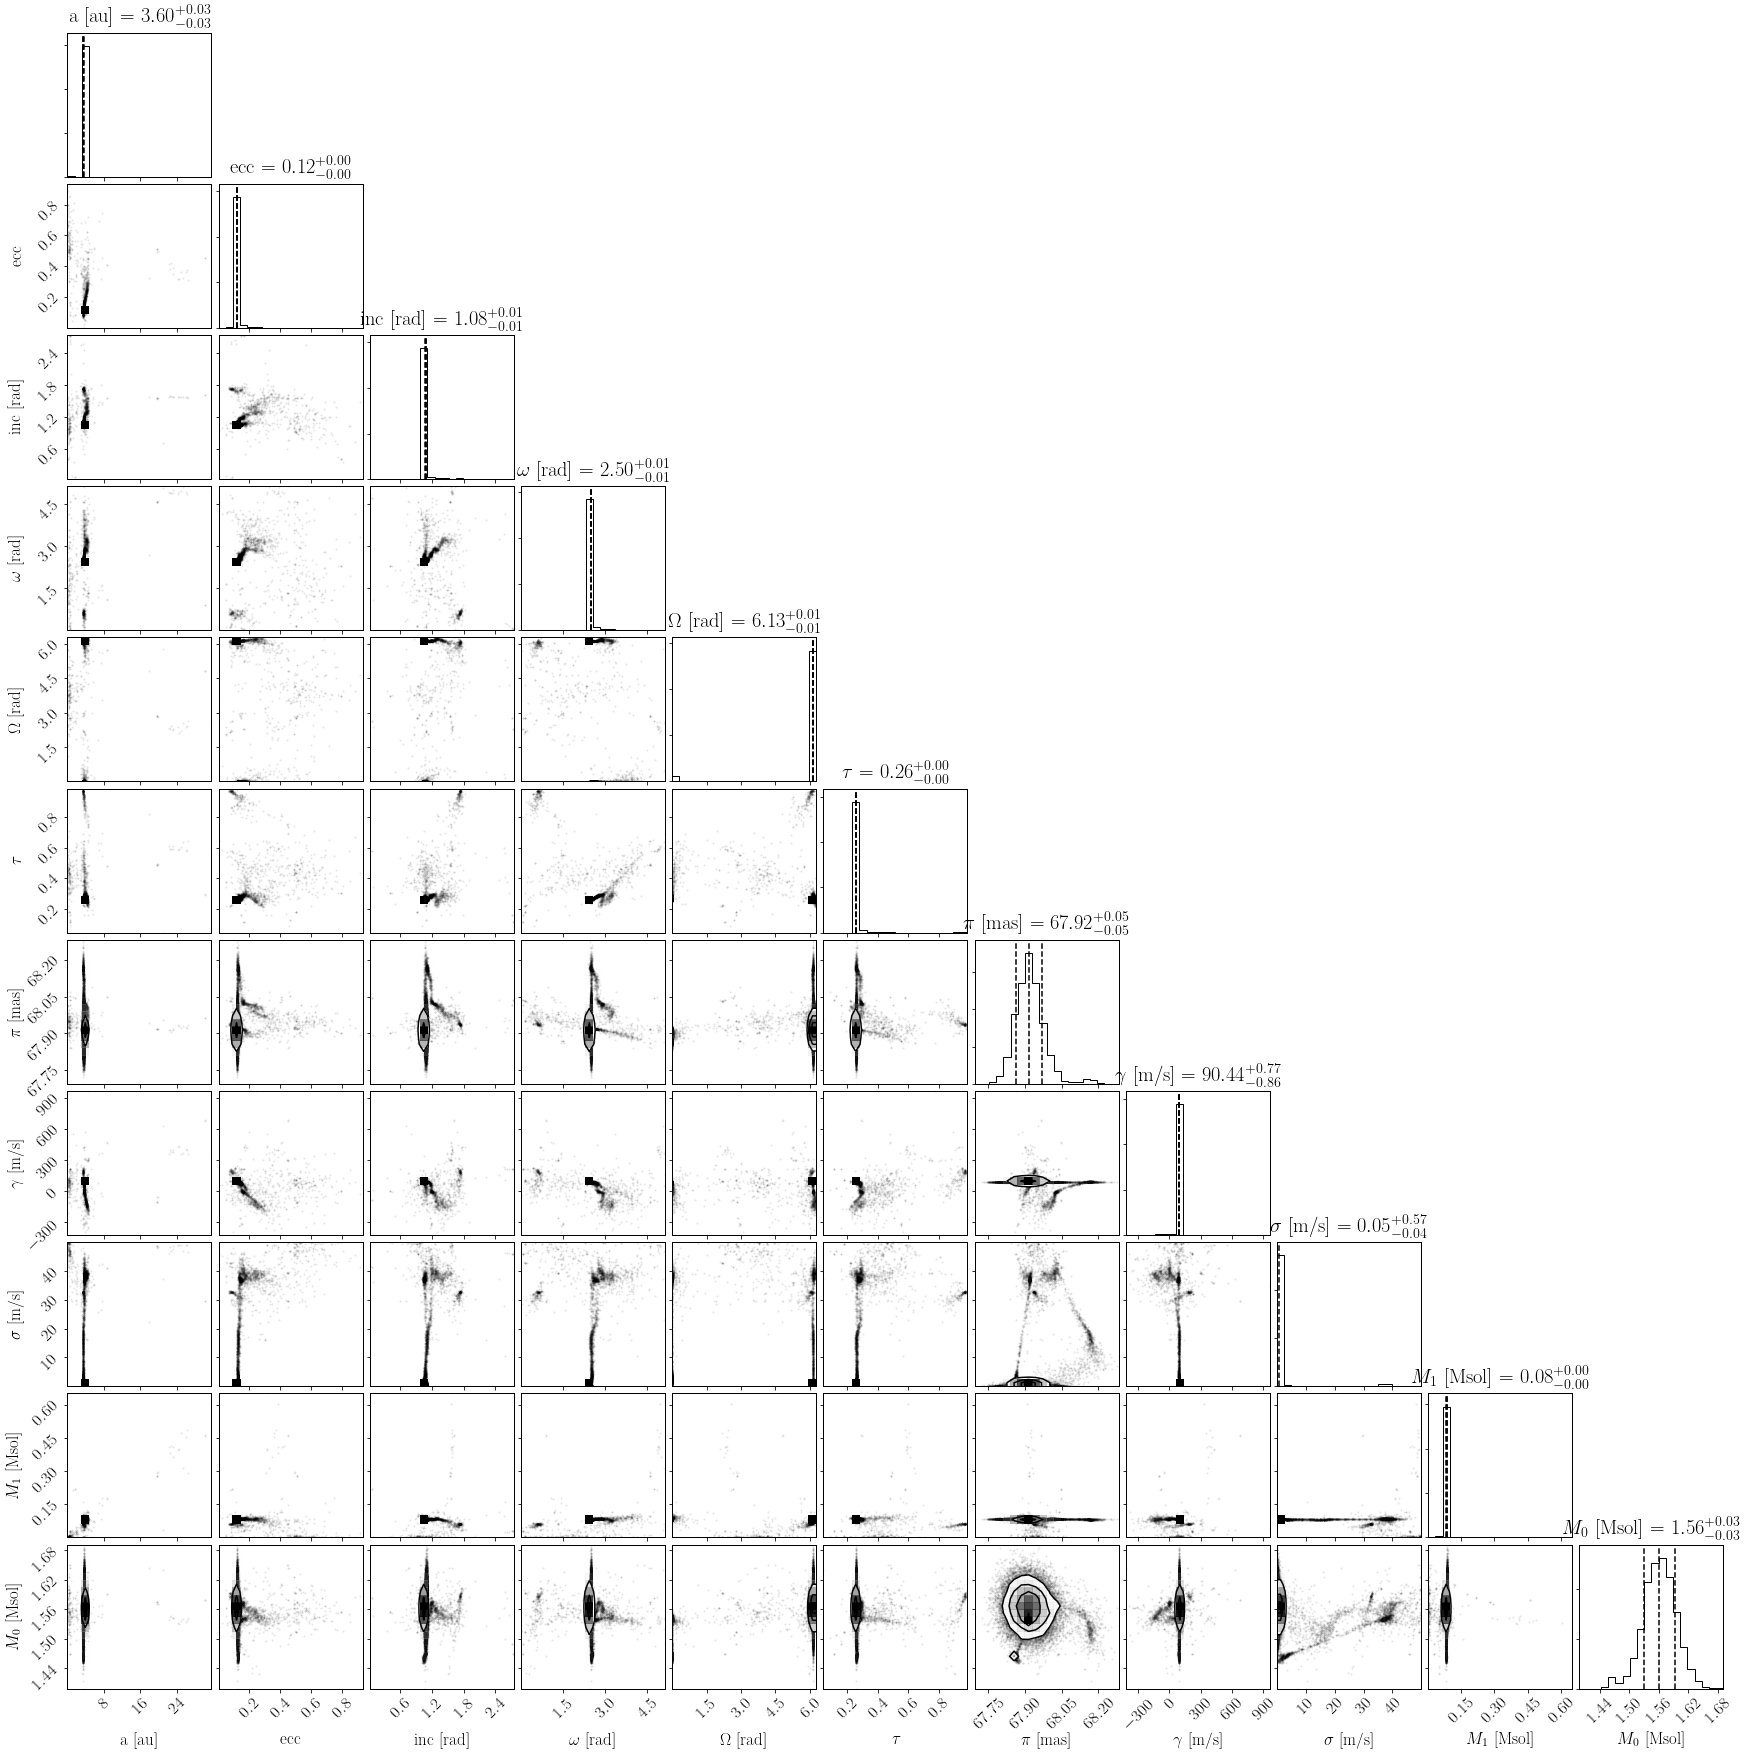

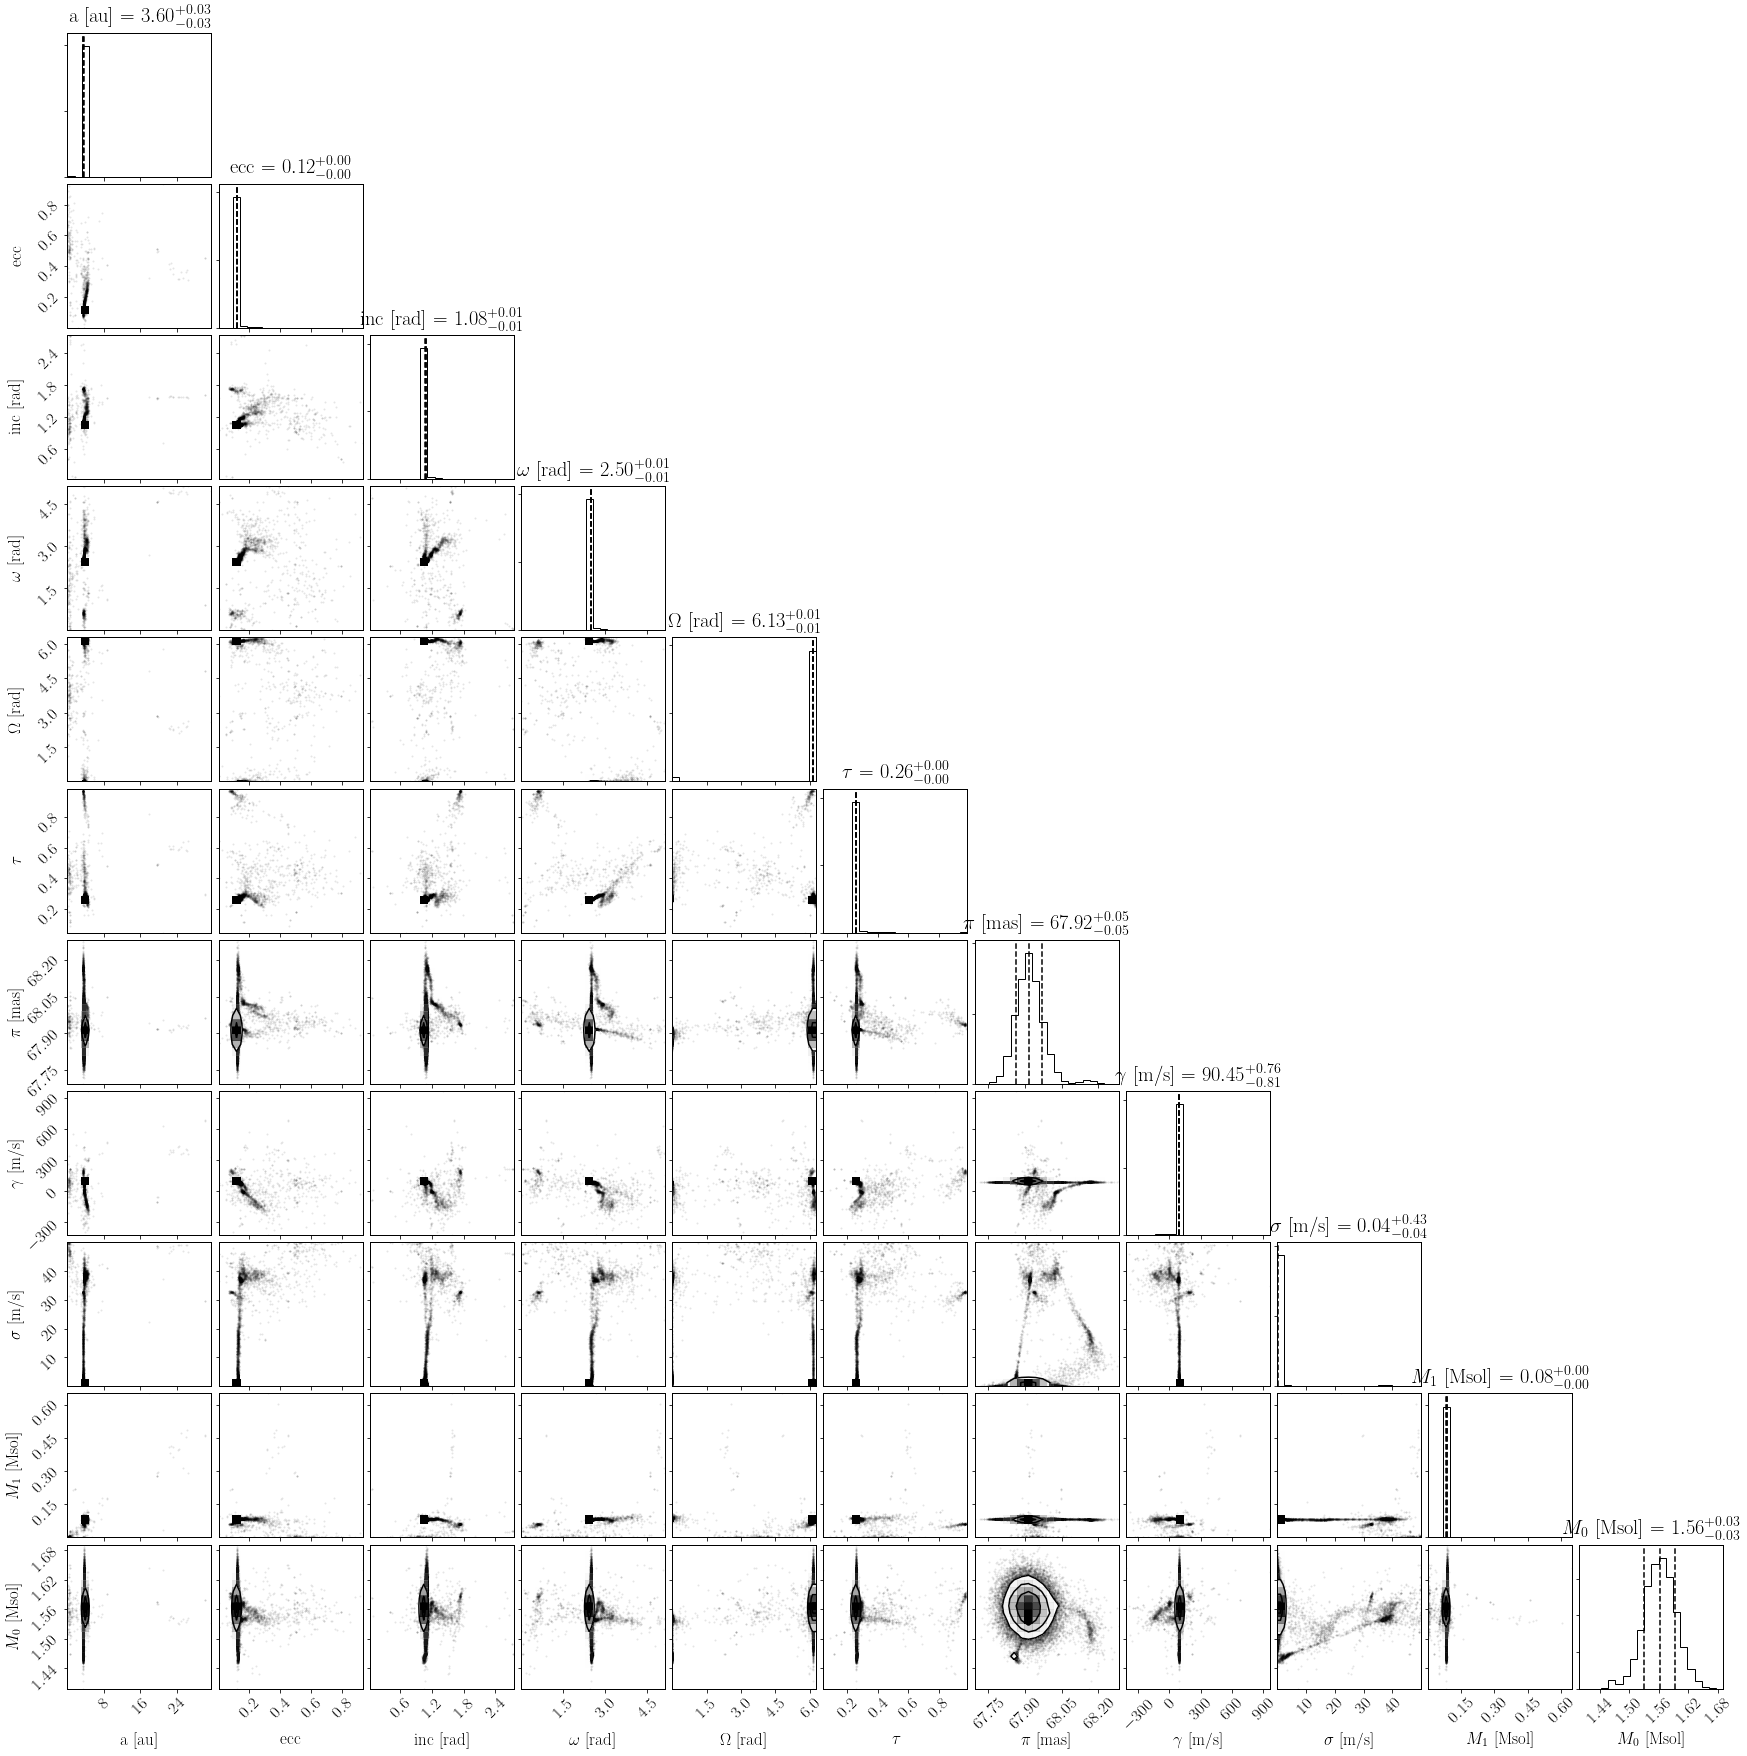

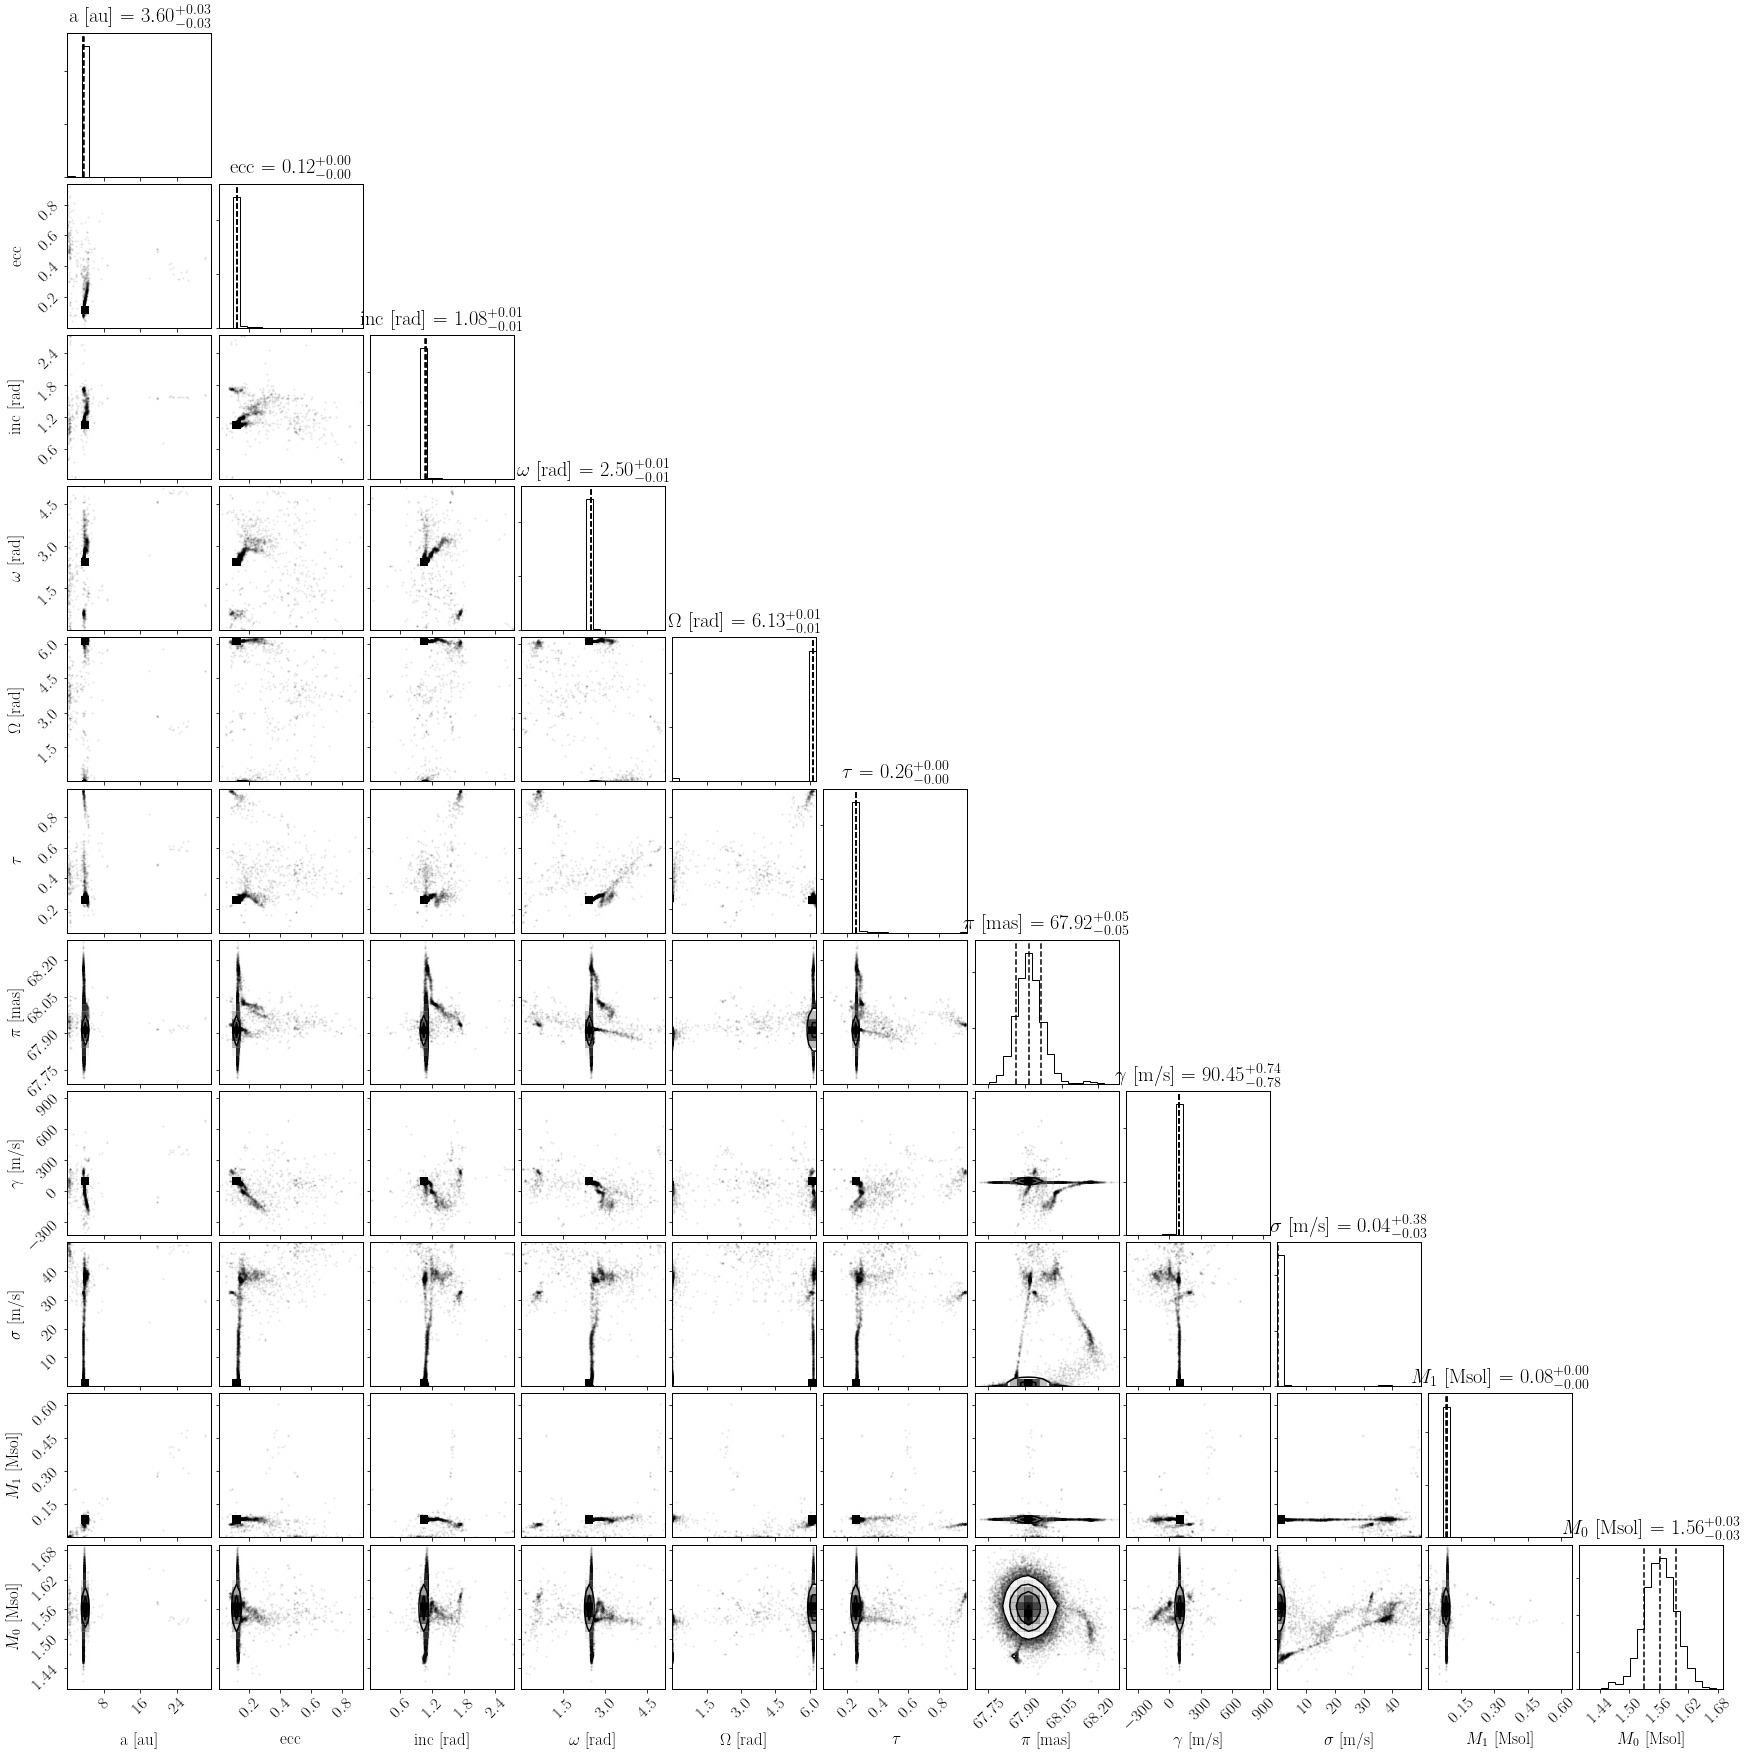

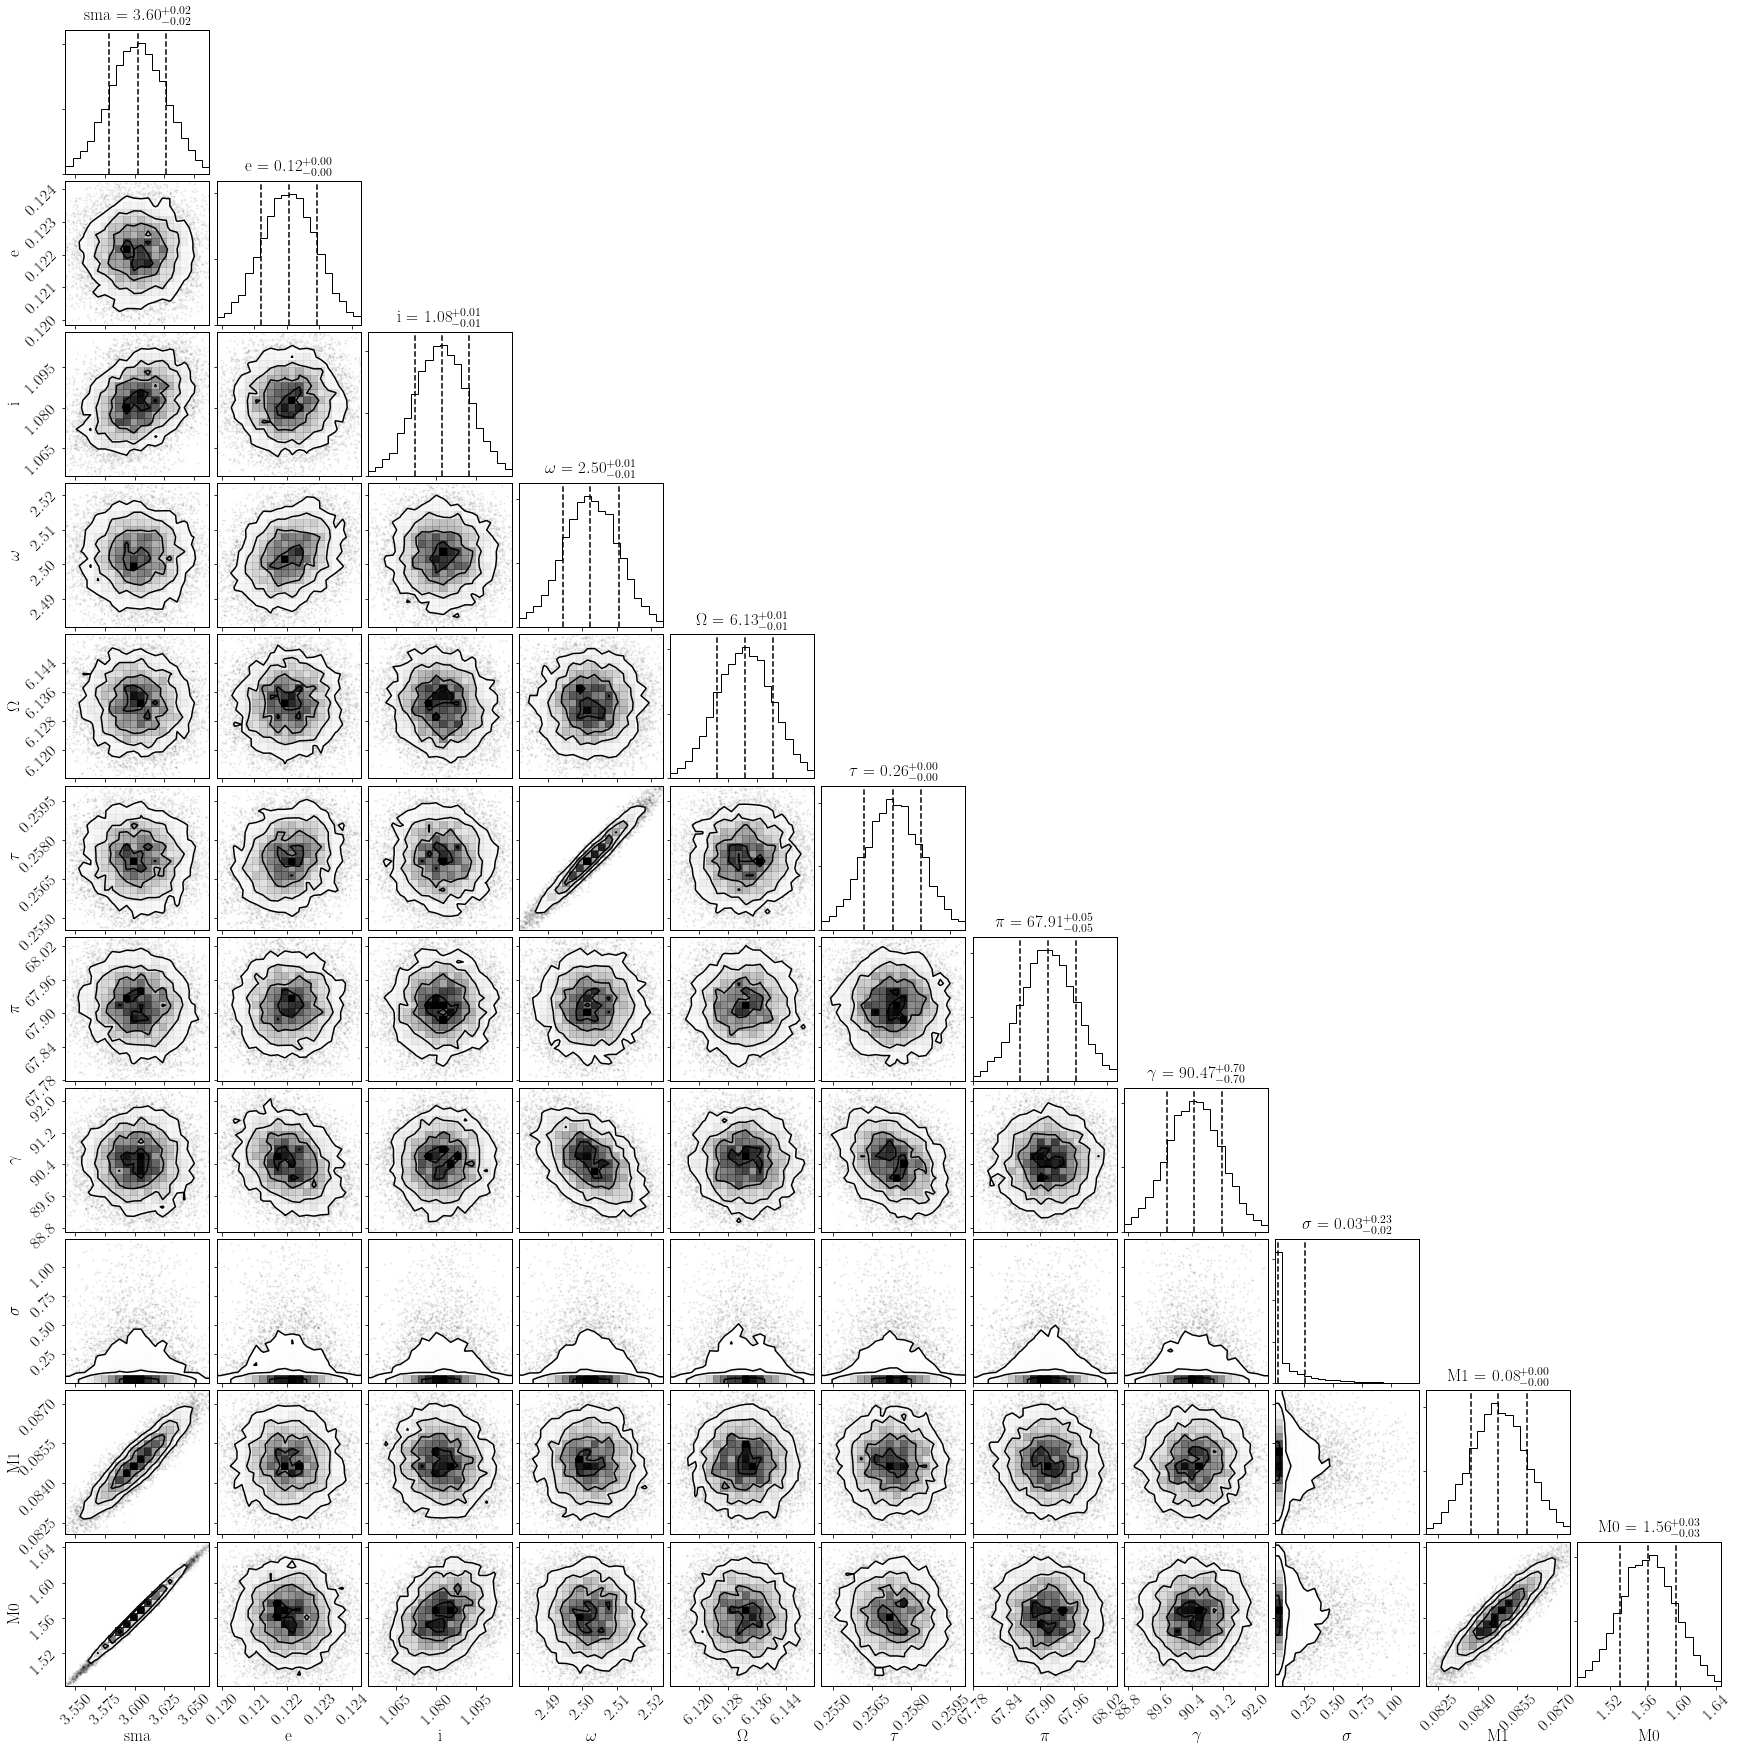

In [26]:
today = datetime.now()
path = '/Users/rtejada/Desktop/'
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$',
               '$\sigma$','M1','M0']

#change 'simuldata2' when running different data!!!

directory = path + 'mcmc_simuldata0/mcmcrun/' + today.strftime('%Y%m%d') + '/'
os.makedirs(directory)

for i in range(5):
    #running the sampler:
    my_driver.sampler.run_sampler(total_orbits, burn_steps=0, thin=thin)
    chain = my_driver.sampler.chain
    print('The chain shape is:',np.shape(chain))
    #saving each sampler chainL
    pkl_file = open(directory + 'mcmcchains_run%1d.txt' % i,'wb')
    pickle.dump(chain,pkl_file)
    
    #plotting and saving corner plots:
    corner_plot_fig = my_driver.sampler.results.plot_corner(show_titles=True,
                                     quantiles=[0.16,0.5,0.84]) # Creates a corner plot and returns Figure object
    corner_plot_fig.savefig(directory + 'cornerplot%1d.pdf' % i)
    
    for j in range(15):
        with PdfPages(directory+'mcmc%1d_temps%1d.pdf' % (i,j)) as pdf:
            shape = np.shape(chain)
            num_steps = shape[2]
            num_params = shape[3]
            num_walkers = shape[1]
            for p in range(num_params):
                pname = param_names[p]
                fig = plt.figure(figsize = (8,5))
                for x in range(num_walkers):
                    #makes trend plot
                    plt.plot(range(num_steps),my_driver.sampler.chain[j,x,:,p],alpha=0.7,linewidth=2)
                    #plt.axhline(wd_params[p],ls='--',c='k')
                plt.ylabel(pname)
                plt.xlabel('steps')
                plt.minorticks_on()
                pdf.savefig()
                #plt.show()
                plt.close()
    print('Finished with %1d iterations!' % i)
                
flatchain = np.reshape(chain[0],(-1,11))
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,range=np.ones(len(param_names))*0.99,title_kwargs={"fontsize": 17})
corner_fig.savefig(directory + 'flatchain_cornerplot.pdf')

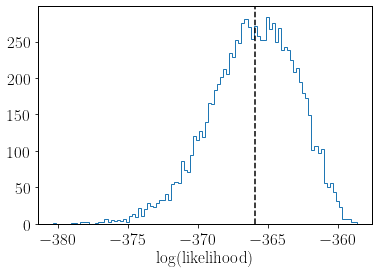

In [27]:
plt.hist(s.lnlikes,bins=100,histtype='step')
plt.axvline(x=np.median(s.lnlikes),c='k',ls='--')
plt.xlabel('$\log(\mathrm{likelihood})$')
#plt.xlim(-2000,2000)
plt.show()

In [28]:
median_pars = np.median(flatchain,axis=0)

In [29]:
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P

#changing the orbitize paramter output order from orbitize to fit in our calc_orbit function
def orb2toy(orb_params):
    toy_order = [10,9,0,1,3,4,2,5,6,7,8]
    orb_testparams = [orb_params[i] for i in toy_order]
    period = sma2p(orb_testparams[2],orb_testparams[0],orb_testparams[1])
    orb_testparams[2] = period
    tperi = Tperi(orb_testparams[7],0.0,orb_testparams[2])
    orb_testparams[7] = tperi

    return orb_testparams

In [30]:
parameters

m0        m1            P       ecc      argp       lan       inc  \
0  1.564479  0.085178  1945.688713  0.122813  2.500799  6.131192  1.073319   
1  1.467623  0.281448  7680.352384  0.541629  3.365739  0.189799  0.766443   
2  1.706174  0.005215  3247.453347  0.440817  5.803546  3.831127  0.651111   
3  1.390054  0.010942  1414.304376  0.219417  3.466953  0.259704  0.889410   
4  2.971407  0.018634  4307.746537  0.418262  2.772717  5.184585  1.509494   

   tperi        plx      gamma      sigma  
0  500.0  67.913080  91.184153   3.286882  
1  500.0  70.358874  43.117884  13.313936  
2  500.0  99.960529  26.053640   7.382694  
3  500.0  95.129581  92.618208   9.715780  
4  500.0  50.011293  37.061491  17.599855

In [31]:
pred_params = orb2toy(median_pars)
print(pred_params)

[1.5633995061974826, 0.08478681556508033, 1945.2833381310097, 0.12206787072555753, 2.502389612613243, 6.132688252759156, 1.0820207664359505, 500.54216640546434, 67.913743051082, 90.47438251240936, 0.025963921591129376]


In [32]:
raoff_pred,decoff_pred,rv_pred = calc_orbit(pred_params,np.arange(0,pred_params[2]))

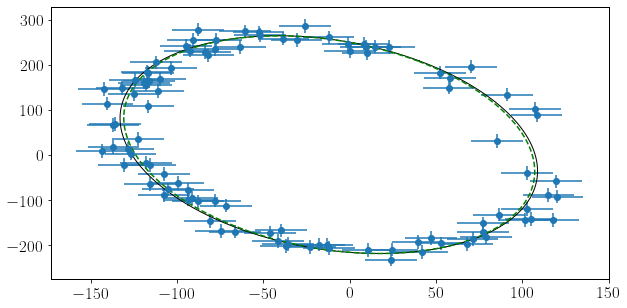

In [37]:
plt.figure(figsize=(10,5))
plt.plot(raoff,decoff,'k',lw=1)
plt.plot(raoff_pred,decoff_pred,'g--')
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
plt.show()

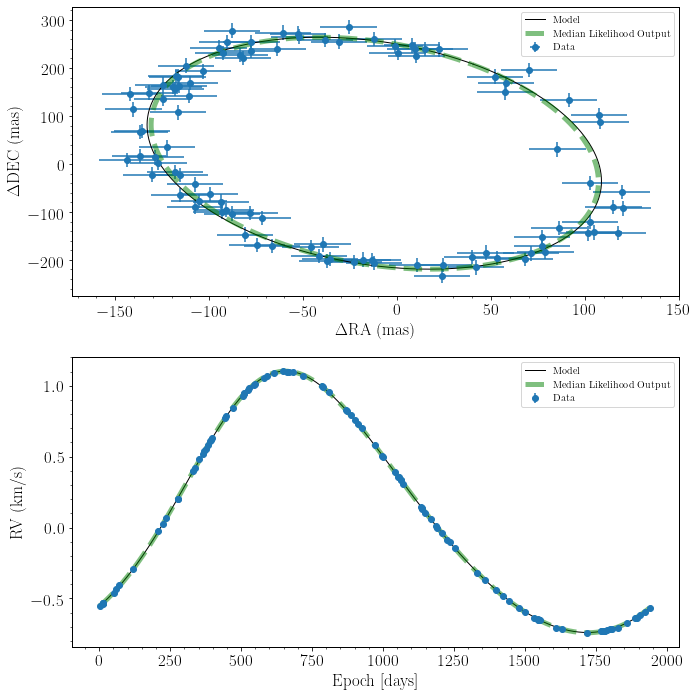

In [42]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(raoff,decoff,'k',lw=1,label='Model')
ax[0].plot(raoff_pred,decoff_pred,'g--',lw=5,alpha=0.5,label='Median Likelihood Output')
ax[0].errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o',label='Data')
ax[0].set_xlabel('$\Delta$RA (mas)')
ax[0].set_ylabel('$\Delta$DEC (mas)')
ax[0].minorticks_on()
ax[0].legend(prop={'size': 10})

ax[1].plot(np.arange(0,parameters.loc[0][2]),rv/1000.0,'k',lw=1,label='Model')
ax[1].plot(np.arange(0,pred_params[2]),rv_pred/1000.0,'g--',lw=5,alpha=0.5,label='Median Likelihood Output')
ax[1].errorbar(data['epoch'],data['rv'],yerr=data['rv_err'],fmt='o',label='Data')
ax[1].set_xlabel('Epoch [days]')
ax[1].set_ylabel('RV (km/s)')
ax[1].minorticks_on()
ax[1].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

In [43]:
max_params = s.post[np.argmax(s.lnlikes)]
best_params = orb2toy(max_params)
raoff_best,decoff_best,rv_best = calc_orbit(best_params,np.arange(0,best_params[2]))

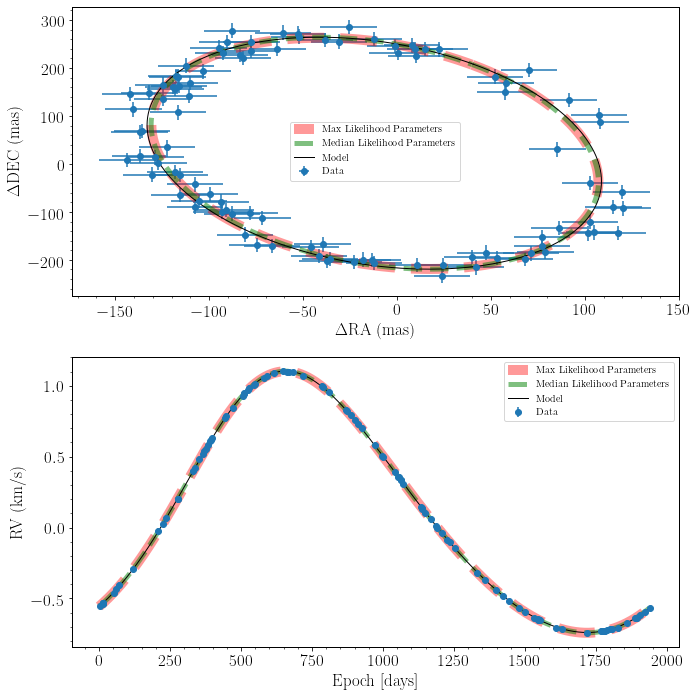

In [47]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(raoff_best,decoff_best,'r--',lw=10,alpha=0.4,label='Max Likelihood Parameters')
ax[0].plot(raoff_pred,decoff_pred,'g--',lw=5,alpha=0.5,label='Median Likelihood Parameters')
ax[0].plot(raoff,decoff,'k',lw=1,label='Model')
ax[0].errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o',label='Data')
ax[0].set_xlabel('$\Delta$RA (mas)')
ax[0].set_ylabel('$\Delta$DEC (mas)')
ax[0].minorticks_on()
ax[0].legend(prop={'size': 10})

ax[1].plot(np.arange(0,best_params[2]),rv_best/1000.0,'r--',lw=10,alpha=0.4,label='Max Likelihood Parameters')
ax[1].plot(np.arange(0,pred_params[2]),rv_pred/1000.0,'g--',lw=5,alpha=0.5,label='Median Likelihood Parameters')
ax[1].plot(np.arange(0,parameters.loc[0][2]),rv/1000.0,'k',lw=1,label='Model')
ax[1].errorbar(data['epoch'],data['rv'],yerr=data['rv_err'],fmt='o',label='Data')
ax[1].set_xlabel('Epoch [days]')
ax[1].set_ylabel('RV (km/s)')
ax[1].minorticks_on()
ax[1].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

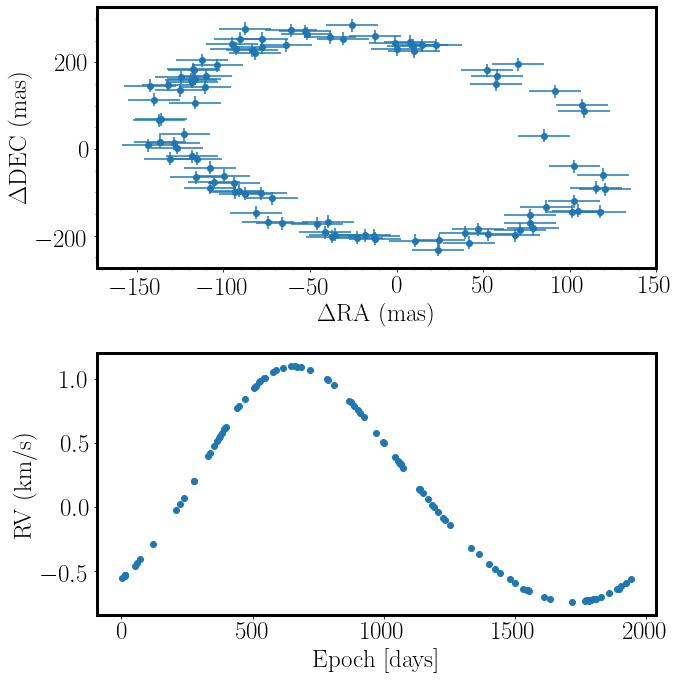

In [54]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

#ax[0].plot(raoff_best,decoff_best,'r--',lw=10,alpha=0.4,label='Max Likelihood Parameters')
#ax[0].plot(raoff_pred,decoff_pred,'g--',lw=5,alpha=0.5,label='Median Likelihood Parameters')
#ax[0].plot(raoff,decoff,'k',lw=1,label='Model')
ax[0].errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o',label='Data')
ax[0].set_xlabel('$\Delta$RA (mas)')
ax[0].set_ylabel('$\Delta$DEC (mas)')
ax[0].minorticks_on()
#ax[0].legend(prop={'size': 10})

#ax[1].plot(np.arange(0,best_params[2]),rv_best/1000.0,'r--',lw=10,alpha=0.4,label='Max Likelihood Parameters')
#ax[1].plot(np.arange(0,pred_params[2]),rv_pred/1000.0,'g--',lw=5,alpha=0.5,label='Median Likelihood Parameters')
#ax[1].plot(np.arange(0,parameters.loc[0][2]),rv/1000.0,'k',lw=1,label='Model')
ax[1].errorbar(data['epoch'],data['rv'],yerr=data['rv_err'],fmt='o',label='Data')
ax[1].set_xlabel('Epoch [days]')
ax[1].set_ylabel('RV (km/s)')
#ax[1].minorticks_on()
#ax[1].legend(prop={'size': 10})

plt.tight_layout()
plt.savefig('/Users/rtejada/Desktop/Slide_Presentation_figures/dataplot.pdf')
plt.show()